In [ ]:
#|default_exp core

# Gaspard's source

## Setup

In [ ]:
#| export
import inspect, typing, mimetypes, base64, json, ast, os, time
import google.generativeai as genai
from google.generativeai.types.generation_types import GenerateContentResponse, GenerationConfig
from google.generativeai.protos import FunctionCall, Content, FunctionResponse
from google.generativeai.protos import GenerateContentResponse as GCR

import toolslm
from toolslm.funccall import *

from fastcore.meta import delegates
from fastcore.utils import *

from collections import abc

In [ ]:
#| hide
from nbdev import show_doc

try: from IPython import display
except: display=None

In [ ]:
#| export
UsageMetadata = GCR.UsageMetadata
empty = inspect.Parameter.empty

In [ ]:
#| exports
models = 'gemini-1.5-pro-exp-0827', 'gemini-1.5-flash-exp-0827','gemini-1.5-pro','gemini-1.5-flash'

These are the latest version of Gemini models available at the time of writing.

In [ ]:
model = models[-1]

We'll use gemini-1.5-flash for the examples since it's faster and cheaper.

## Gemini SDK

Follow the [instructions](https://aistudio.google.com/app/apikey) to generate an API key, and set it as an evironment variable.

In [ ]:
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

In [ ]:
cli = genai.GenerativeModel(model)

In [ ]:
r = cli.generate_content("Hi, I'm Faisal!")
r

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Hello Faisal! It's nice to meet you.  What can I do for you today? \n"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "index": 0,
          "safety_ratings": [
            {
              "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_HATE_SPEECH",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_HARASSMENT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
              "probability": "NEGLIGIBLE"
            }
          ]
        }
  

## Formatting output

In [ ]:
#| exports
def find_block(r:abc.Mapping, # The message to look in
              ):
    "Find the content in `r`."
    m = nested_idx(r, 'candidates', 0)
    if not m: return m
    if hasattr(m, 'content'): return m.content 
    else: return m

In [ ]:
find_block(r)

parts {
  text: "Hello Faisal! It\'s nice to meet you.  What can I do for you today? \n"
}
role: "model"

In [ ]:
#| exports
def contents(r):
    "Helper to get the contents from response `r`."
    blk = find_block(r)
    if not blk: return r
    if hasattr(blk, 'parts'): return getattr(blk,'parts')[0].text
    return blk

In [ ]:
contents(r)

"Hello Faisal! It's nice to meet you.  What can I do for you today? \n"

In [ ]:
#| exports
@patch()
def _repr_markdown_(self:GenerateContentResponse):
    met = list(self.to_dict()['candidates'][0].items()) + list(self.to_dict()['usage_metadata'].items())
    det = '\n- '.join(f'{k}: {v}' for k,v in met)
    res = contents(self)
    if not res: return f"- {det}"
    return f"""{contents(self)}

<details>

- {det}

</details>"""

In [ ]:
r

Hello Faisal! It's nice to meet you.  What can I do for you today? 


<details>

- content: {'parts': [{'text': "Hello Faisal! It's nice to meet you.  What can I do for you today? \n"}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 8
- candidates_token_count: 20
- total_token_count: 28
- cached_content_token_count: 0

</details>

In [ ]:
r.usage_metadata

prompt_token_count: 8
candidates_token_count: 20
total_token_count: 28

In [ ]:
#| exports
def usage(inp=0, # Number of input tokens
          out=0  # Number of output tokens
         ):
    "Slightly more concise version of `Usage`."
    return UsageMetadata(prompt_token_count=inp, candidates_token_count=out)

In [ ]:
usage(5)

prompt_token_count: 5

In [ ]:
#| exports
@patch(as_prop=True)
def total(self:UsageMetadata): return self.prompt_token_count+self.candidates_token_count

In [ ]:
#| exports
@patch
def __repr__(self:UsageMetadata): return f'In: {self.prompt_token_count}; Out: {self.candidates_token_count}; Total: {self.total}'

In [ ]:
r.usage_metadata

In: 8; Out: 20; Total: 28

In [ ]:
#| exports
@patch
def __add__(self:UsageMetadata, b):
    "Add together each of `input_tokens` and `output_tokens`"
    return usage(self.prompt_token_count+b.prompt_token_count, self.candidates_token_count+b.candidates_token_count)

In [ ]:
r.usage_metadata+r.usage_metadata

In: 16; Out: 40; Total: 56

## Creating messages

In [ ]:
def mk_msg(content, role='user', **kw):
    if isinstance(content, GenerateContentResponse): return find_block(content)
    if not isinstance(content, list): content=[content]
    return dict(role=role, parts=content, **kw)

In [ ]:
prompt = "I'm Faisal"
m = mk_msg(prompt)
m

{'role': 'user', 'parts': ["I'm Faisal"]}

In [ ]:
r = cli.generate_content([m], generation_config=GenerationConfig(max_output_tokens=100))
r

Nice to meet you, Faisal! What can I do for you today? 


<details>

- content: {'parts': [{'text': 'Nice to meet you, Faisal! What can I do for you today? \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 5
- candidates_token_count: 16
- total_token_count: 21
- cached_content_token_count: 0

</details>

In [ ]:
msgs = [mk_msg(prompt), mk_msg(r), mk_msg('I forgot my name. Can you remind me please?')]
msgs

[{'role': 'user', 'parts': ["I'm Faisal"]},
 parts {
   text: "Nice to meet you, Faisal! What can I do for you today? \n"
 }
 role: "model",
 {'role': 'user', 'parts': ['I forgot my name. Can you remind me please?']}]

In [ ]:
cli.generate_content(msgs, generation_config=GenerationConfig(max_output_tokens=100))

You're right, you told me your name is Faisal! 😄  

Is there anything else I can help you with? 


<details>

- content: {'parts': [{'text': "You're right, you told me your name is Faisal! 😄  \n\nIs there anything else I can help you with? \n"}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 35
- candidates_token_count: 26
- total_token_count: 61
- cached_content_token_count: 0

</details>

## Client

In [ ]:
#| exports
class Client:
    def __init__(self, model, cli=None, sp=None):
        "Basic LLM messages client."
        self.model,self.use = model,usage(0,0)
        self.sp = sp
        self.c = (cli or genai.GenerativeModel(model, system_instruction=sp))

In [ ]:
c = Client(model)
c.use

In: 0; Out: 0; Total: 0

In [ ]:
#| exports
@patch
def _r(self:Client, r:GenerateContentResponse):
    "Store the result of the message and accrue total usage."
    self.result = r
    if getattr(r,'usage_metadata',None): self.use += r.usage_metadata
    return r

In [ ]:
c._r(r)
c.use

In: 5; Out: 16; Total: 21

In [ ]:
#| export
def get_stream(r):
    for o in r:
        o = contents(o)
        if o and isinstance(o, str): yield(o)

In [ ]:
#| export
@patch
def _set_sp(self:Client, sp:str):
    if sp != self.sp:
        self.sp = sp
        self.c = genai.GenerativeModel(model, system_instruction=self.sp)

Gemini cli requires passing the system prompt when creating the client, so we recreate the client for now.

TODO: Ask Google to surface this option to generate_content function, since they're passing the system prompt to each request anyways [under the hood](https://github.com/googleapis/python-aiplatform/blob/f89df1f30822d260176487f74c3743cab88a38fd/vertexai/generative_models/_generative_models.py#L446).

In [ ]:
#| exports
@patch
@delegates(genai.GenerativeModel.generate_content)
def __call__(self:Client,
             msgs:list, # List of messages in the dialog
             sp:str=None, # System prompt
             maxtok=4096, # Maximum tokens
             stream:bool=False, # Stream response?
             **kwargs):
    "Make a call to LLM."
    if sp: self._set_sp(sp)
    gc_params = inspect.signature(GenerationConfig.__init__).parameters
    gc_kwargs = {k: v for k, v in kwargs.items() if k in gc_params}
    gen_config = GenerationConfig(max_output_tokens=maxtok, **gc_kwargs)
    gen_params = inspect.signature(self.c.generate_content).parameters
    gen_kwargs = {k: v for k, v in kwargs.items() if k in gen_params}
    r = self.c.generate_content(
        contents=msgs, generation_config=gen_config, stream=stream, **gen_kwargs)
    if not stream: return self._r(r)
    else: return get_stream(map(self._r, r))

In [ ]:
msgs = [mk_msg('Hi!')]

In [ ]:
c(msgs)

Hi there! What can I do for you today? 


<details>

- content: {'parts': [{'text': 'Hi there! What can I do for you today? \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 3
- candidates_token_count: 12
- total_token_count: 15
- cached_content_token_count: 0

</details>

In [ ]:
c.use

In: 8; Out: 28; Total: 36

In [ ]:
for o in c(msgs, stream=True): print(o, end='')

Hi! What can I do for you today? 


In [ ]:
c.use

In: 14; Out: 41; Total: 55

Gemini cli requires passing the system prompt when creating the client, but we didn't pass one at creation time.
Let's make sure that it gets set properly when we call the client later.

In [ ]:
sysp = "Respond only in emojis"

In [ ]:
c(msgs, sp=sysp)

👋 


<details>

- content: {'parts': [{'text': '👋 \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 7
- candidates_token_count: 1
- total_token_count: 8
- cached_content_token_count: 0

</details>

## Tool Use

In [ ]:
def sums(
    a:int,  # First thing to sum
    b:int # Second thing to sum
) -> int: # The sum of the inputs
    "Adds a + b."
    print(f"Finding the sum of {a} and {b}")
    return a + b

In [ ]:
sysp = "You are a helpful assistant. When using tools, be sure to pass all required parameters, at minimum."

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"

Google's Genai API handles schema exatraction under the hood, so we can just directly pass the functions

In [ ]:
msgs = [mk_msg(pr)]
r = c(msgs, sp=sysp, tools=[sums])
r

- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 86
- candidates_token_count: 29
- total_token_count: 115
- cached_content_token_count: 0

In [ ]:
m = find_block(r)
m

parts {
  function_call {
    name: "sums"
    args {
      fields {
        key: "b"
        value {
          number_value: 6458932
        }
      }
      fields {
        key: "a"
        value {
          number_value: 604542
        }
      }
    }
  }
}
role: "model"

In [ ]:
func = m.parts[0].function_call
func

name: "sums"
args {
  fields {
    key: "b"
    value {
      number_value: 6458932
    }
  }
  fields {
    key: "a"
    value {
      number_value: 604542
    }
  }
}

In [ ]:
#| exports
def _mk_ns(*funcs:list[callable]) -> dict[str,callable]:
    "Create a `dict` of name to function in `funcs`, to use as a namespace"
    return {f.__name__:f for f in funcs}

In [ ]:
#| exports
def call_func(fc:FunctionCall, # FunctionCall block from the response
              ns:Optional[abc.Mapping]=None, # Namespace to search for tools, defaults to `globals()`
              obj:Optional=None # Object to search for tools
             ):
    "Call the function in the tool response `tr`, using namespace `ns`."
    if ns is None: ns=globals()
    if not isinstance(ns, abc.Mapping): ns = _mk_ns(*ns)
    func = getattr(obj, fc.name, None)
    if not func: func = ns[fc.name]
    return func(**(fc.args))

In [ ]:
ns = _mk_ns(sums)
res = call_func(func, ns=ns)
res

Finding the sum of 604542.0 and 6458932.0


7063474.0

In [ ]:
#| exports
def mk_toolres(
    r:abc.Mapping, # Tool use request response
    ns:Optional[abc.Mapping]=None, # Namespace to search for tools
    obj:Optional=None # Class to search for tools
    ):
    "Create a `tool_result` message from response `r`."
    parts = find_block(r).parts
    tcs = [p.function_call for p in parts if hasattr(p, 'function_call')]
    res = [mk_msg(r)]
    tc_res = []
    for func in (tcs or []):
        if not func: continue
        cts = str(call_func(func, ns=ns, obj=obj))
        tc_res.append(FunctionResponse(name=func.name, response={'result': cts}))
    if tc_res: res.append(mk_msg(tc_res, 'function'))
    return res

In [ ]:
tr = mk_toolres(r, ns=ns)
tr[1]

Finding the sum of 604542.0 and 6458932.0


{'role': 'function',
 'parts': [name: "sums"
  response {
    fields {
      key: "result"
      value {
        string_value: "7063474.0"
      }
    }
  }]}

In [ ]:
msgs += tr

In [ ]:
res = c(msgs, sp=sysp, tools=[sums])
res

7063474.0 


<details>

- content: {'parts': [{'text': '7063474.0 \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 138
- candidates_token_count: 9
- total_token_count: 147
- cached_content_token_count: 0

</details>

We can also use tool calling to force the model to return structured outputs

In [ ]:
#| exports
@patch
@delegates(Client.__call__)
def structured(self:Client,
               msgs:list, # List of messages in the dialog
               ns:Optional[abc.Mapping]=None, # Namespace to search for tools
               obj:Optional=None, # Class to search for tools
               **kwargs):
    "Return the value of all tool calls (generally used for structured outputs)"
    res = self(msgs, **kwargs)
    if ns is None: ns=globals()
    parts = find_block(res).parts
    funcs = [p.function_call for p in parts if hasattr(p, 'function_call')]
    tcs = [call_func(func, ns=ns, obj=obj) for func in funcs]
    return tcs

In [ ]:
class Recipe:
    """
    A structure for representing recipes.
    """
    def __init__(self, 
                 recipe_name: str, # The name of the recipe   
                 ingredients: list[str] # The igredients needed for the recipe
                ):
        store_attr()
        
    __repr__ = basic_repr(['recipe_name', 'ingredients'])

Gemini API schema extraction doesn't work very well for Class definitions so we define a factory method as a workaround.

In [ ]:
def create_recipe(recipe_name: str, # The name of the recipe   
                 ingredients: list[str] # The igredients needed for the recipe
                 )->Recipe:
    return Recipe(recipe_name=recipe_name, ingredients=ingredients)

In [ ]:
pr = "Give me a receipe for chocolate chip cookies"
recipe = c.structured(pr, sp=sysp, tools=[create_recipe])[0]

In [ ]:
recipe

__main__.Recipe(recipe_name='Chocolate Chip Cookies', ingredients=['flour', 'sugar', 'butter', 'eggs', 'chocolate chips'])

We see that using tool calling, we can get the model to return the recipe as a recipe object.

Now let's try a slightly more complicated example with a nested structure.

In [ ]:
class Turn:
    """A turn in the conversation."""
    def __init__(
        self,
        user_a: str, # The first user's message
        user_b: str, # The second user's message
    ): store_attr()
    
    __repr__ = basic_repr(['user_a', 'user_b'])
    def __str__(self): return "Turn created."

class Conversation:
    """A conversation between two users."""
    def __init__(
        self,
        turns: List[Turn], # The turns in the conversation
    ): store_attr()
    
    __repr__ = basic_repr('turns')
    def __str__(self): return "Conversation created."


def create_conversation(
    user_a_turns: List[str], # List of turns for the first person in the conversation
    user_b_turns: List[str] # List of turns for the second person in the conversation
)->Conversation:
    """
    This is used to create a conversation between two users.
    """
    return Conversation([Turn(a,b) for a,b in zip(user_a_turns, user_b_turns)])

In [ ]:
pr = "Generate a conversation between a python programmer and a rust programmer."
conv = c.structured(pr, sp=sysp, tools=[create_conversation])[0]

In [ ]:
conv.turns

[__main__.Turn(user_a='Hello, I am a Python programmer. What about you?', user_b='Hi there! I am a Rust programmer.'),
 __main__.Turn(user_a='Interesting. I have heard Rust is quite fast.', user_b='Yes, Rust is known for its performance and memory safety.'),
 __main__.Turn(user_a='I see, thanks for the info!', user_b='You are welcome!')]

As we can see, the model is able to return the necessary information to create the conversation object.

We can also force a particular set of tools to be used using, `tool_choice`. Here's an example of how to do that for genai api.

In [ ]:
#| exports
def mk_tool_choice(choose: list)->dict:
    return {"function_calling_config": {"mode": "ANY", "allowed_function_names": [x.__name__ for x in choose]}}

In [ ]:
tool_choice = mk_tool_choice([sums])
tool_choice

{'function_calling_config': {'mode': 'ANY',
  'allowed_function_names': ['sums']}}

We'll use this with the Chat class that we'll create next.

## Chat

We'll create a Chat class that will handle formatting of messages and passing along system prompts and tools, so we don't have to worry about doing that manually each time.

In [ ]:
#| exports
class Chat:
    def __init__(self,
                 model:Optional[str]=None, # Model to use (leave empty if passing `cli`)
                 cli:Optional[Client]=None, # Client to use (leave empty if passing `model`)
                 sp=None, # Optional system prompt
                 tools:Optional[list]=None,  # List of tools to make available
                 tool_choice:Optional[str]=None): # Forced tool choice
        "Gemini chat client."
        assert model or cli
        self.c = (cli or Client(model, sp=sp))
        self.h,self.sp,self.tools,self.tool_choice = [],sp,tools,tool_choice
    
    @property
    def use(self): return self.c.use

In [ ]:
sp = "Never mention what tools you use."
chat = Chat(model, sp=sp)
chat.c.use, chat.h

(In: 0; Out: 0; Total: 0, [])

In [ ]:
#| exports
@patch
def _stream(self:Chat, res):
    yield from res
    self.h += mk_toolres(self.c.result, ns=self.tools, obj=self)

In [ ]:
#| exports
@patch
@delegates(genai.GenerativeModel.generate_content)
def __call__(self:Chat,
             pr=None,  # Prompt / message
             temp=0, # Temperature
             maxtok=4096, # Maximum tokens
             stream=False, # Stream response?
             **kwargs):
    if isinstance(pr,str): pr = pr.strip()
    if pr: self.h.append(mk_msg(pr))
    if self.tools: kwargs['tools'] = self.tools
    # NOTE: Gemini specifies tool_choice via tool_config
    if self.tool_choice: kwargs['tool_config'] = mk_tool_choice(self.tool_choice)
    res = self.c(self.h, stream=stream, sp=self.sp, temp=temp, maxtok=maxtok, **kwargs)
    if stream: return self._stream(res)
    self.h += mk_toolres(self.c.result, ns=self.tools, obj=self)
    return res

In [ ]:
chat("I'm Faisal")

Nice to meet you, Faisal! What can I do for you today? 😊 


<details>

- content: {'parts': [{'text': 'Nice to meet you, Faisal! What can I do for you today? 😊 \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 12
- candidates_token_count: 16
- total_token_count: 28
- cached_content_token_count: 0

</details>

Now let's make sure that context is passed properly to subsequent calls

In [ ]:
chat("What's my name?")

Your name is Faisal. 😊  Is there anything else I can help you with? 


<details>

- content: {'parts': [{'text': 'Your name is Faisal. 😊  Is there anything else I can help you with? \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 38
- candidates_token_count: 17
- total_token_count: 55
- cached_content_token_count: 0

</details>

Let's also make sure that streaming works correctly with the Chat interface

In [ ]:
chat = Chat(model, sp=sp)
for o in chat("I'm Faisal", stream=True):
    o = contents(o)
    if o and isinstance(o, str): print(o, end='')

Nice to meet you, Faisal! 👋 What can I do for you today? 😊 


Let's also make sure that tool use works with the Chat interface

In [ ]:
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

In [ ]:
sp = "You are a helpful assistant. When using tools, be sure to pass all required parameters, at minimum."
chat = Chat(model, sp=sp, tools=[sums])
r = chat("I'm Faisal")
r

Nice to meet you, Faisal! How can I help you today? 


<details>

- content: {'parts': [{'text': 'Nice to meet you, Faisal! How can I help you today? \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 72
- candidates_token_count: 14
- total_token_count: 86
- cached_content_token_count: 0

</details>

In [ ]:
chat(pr)

Finding the sum of 604542.0 and 6458932.0


- content: {'parts': [{'function_call': {'name': 'sums', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 8, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 108
- candidates_token_count: 29
- total_token_count: 137
- cached_content_token_count: 0

The model correctly calls the right function in this case.

In [ ]:
chat.h[-1]

{'role': 'function',
 'parts': [name: "sums"
  response {
    fields {
      key: "result"
      value {
        string_value: "7063474.0"
      }
    }
  }]}

If we inspect the history, we can see that the result of the function call has already been added. We can simply call `chat()` to pass this to the model and get a response.

In [ ]:
chat()

604542 + 6458932 = 7063474. 


<details>

- content: {'parts': [{'text': '604542 + 6458932 = 7063474. \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 160
- candidates_token_count: 25
- total_token_count: 185
- cached_content_token_count: 0

</details>

Now let's make sure that `tool_choice` works correctly by forcing the model to pick a particular function.

In [ ]:
def diff(
    a:int, # The number to subtract from
    b:int # The amount to subtract
) -> int: # Result of subtracting b from a
    "Returns a - b."
    print(f"Finding the diff of {a} and {b}")
    return a - b

In [ ]:
sp = "You are a helpful assistant. When using tools, be sure to pass all required parameters, at minimum."
chat = Chat(model, sp=sp, tools=[sums, diff], tool_choice=[diff])
r = chat(f"What is {a}+{b}?")
r

Finding the diff of 604542.0 and 6458932.0


- content: {'parts': [{'function_call': {'name': 'diff', 'args': {'a': 604542.0, 'b': 6458932.0}}}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}, {'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 132
- candidates_token_count: 29
- total_token_count: 161
- cached_content_token_count: 0

We can see that the model calls the function specified by `tool_choice` even though the prompt asks for a summation, which is the expected behvior in this case.

## Images

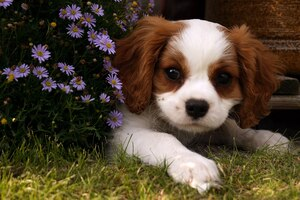

In [ ]:
fn = Path('./samples/puppy.jpg')
display.Image(filename=fn, width=200)

Now that we are passing more than just text, will need a helper function to upload media using Gemini's File API, which is the recomended way of passing media to the model.

In [ ]:
#| exports
def media_msg(fn: Path)->dict:
    f = genai.upload_file(fn)
    return {'file_data': {'mime_type': f.mime_type, 'file_uri': f.uri}}

Let's also update how we pass in text type messages, to be consistent

In [ ]:
#| exports
def text_msg(s:str)->dict:
    return {'text': s}

And finally lets had a helper funciton for make content correctly handles text and other media.

In [ ]:
#| exports
def _mk_content(src):
    "Create appropriate content data structure based on type of content"
    if isinstance(src,str): return text_msg(src)
    else: return media_msg(src)

Now let's make sure it properly handles text vs. Path objects for media

In [ ]:
_mk_content("Hi")

{'text': 'Hi'}

In [ ]:
_mk_content(fn)

{'file_data': {'mime_type': 'image/jpeg',
  'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/6ds7015edz5e'}}

And now we need to update mk_msg to be able to handle multimedia messages correctly

In [ ]:
#| export
def mk_msg(content, role='user', **kw):
    "Create a message"
    if isinstance(content, FunctionResponse): return content
    if isinstance(content, GenerateContentResponse): return find_block(content)
    if content is not None and not isinstance(content, list): content=[content]
    if role == 'user': content = [_mk_content(o) for o in content] if content else ''
    return dict(role=role, parts=content, **kw)

Now, we should just be able to pass a list of multimedia content to our Chat client and it should be able to handle it all under the hood. Let's test it out.

In [ ]:
chat = Chat(model)

In [ ]:
q = "In brief, what color flowers are in this image?"
chat([fn, q])

The flowers in the image are purple. 


<details>

- content: {'parts': [{'text': 'The flowers in the image are purple. \n'}], 'role': 'model'}
- finish_reason: 1
- index: 0
- safety_ratings: [{'category': 9, 'probability': 1, 'blocked': False}, {'category': 8, 'probability': 1, 'blocked': False}, {'category': 7, 'probability': 1, 'blocked': False}, {'category': 10, 'probability': 1, 'blocked': False}]
- token_count: 0
- grounding_attributions: []
- prompt_token_count: 270
- candidates_token_count: 8
- total_token_count: 278
- cached_content_token_count: 0

</details>

Hooray! That works, let's double check the history to make sure that everything is properly formatted and stored.

In [ ]:
chat.h

[{'role': 'user',
  'parts': [{'file_data': {'mime_type': 'image/jpeg',
     'file_uri': 'https://generativelanguage.googleapis.com/v1beta/files/op2zztctwxye'}},
   {'text': 'In brief, what color flowers are in this image?'}]},
 parts {
   text: "The flowers in the image are purple. \n"
 }
 role: "model"]

## Other Media (audio, video, etc.)

Unlike ChatGPT and Claude, Gemini models can also handle audio and video inputs. Since we're using Gemini's File API for handling multimedia content, what we have should just work, except we'll need to make one small modification to the `media_msg` function ...

In [ ]:
#| exports
def media_msg(fn: Path)->dict:
    print(f"Uploading media...", end='')
    f = genai.upload_file(fn)
    while f.state.name == "PROCESSING":
        print('.', end='')
        time.sleep(2)
        f = genai.get_file(f.name)
    return {'file_data': {'mime_type': f.mime_type, 'file_uri': f.uri}}

Since we're uploading potentially larger files, we need to wait for the upload and process to complete so that the media is ready to be consumed by the model.

In [ ]:
# !wget https://storage.googleapis.com/generativeai-downloads/images/GreatRedSpot.mp4
# We'll test this with the example from Gemini's docs
# video_fn = Path('./GreatRedSpot.mp4')
# prompt = "Summarize this video."
# chat = Chat(model)
# chat([video_fn, prompt])

Takes a little while, but works like a charm! Now, let's try an audio file to make sure it also works.

In [ ]:
# audio_fn = Path('./samples/attention_is_all_you_need.mp3')
# prompt = "Is the content of this audio file of a related subject matter to the video?"
# chat([audio_fn, prompt])

Finally, let's check to make sure pdfs work as well.

In [ ]:
# pdf_fn = Path('./samples/attention_is_all_you_need.pdf')
# prompt = "What's mentioned in this pdf that's not mentioned in the previous podcast?"
# chat([pdf_fn, prompt])

Gemini does a pretty good job here!!

In [ ]:
# prompt = "Can you generate an exact transcript of the speech in the podcast?"
# chat([prompt])

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()